# QuantGAN neural network. Pure TCN approach demonstration

Most of the code are in $/backend/$ directory, so it case when this notebook opened in Google Colab

we downloading whole repository into environment to use it's code.

In [9]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !rm -rf quantgan
    !rm -rf sample_data
    !git clone https://bitbucket.org/Neznakomec/quantgan/
    sys.path.append('/content/quantgan/')

In [6]:
if IN_COLAB:
  !pip install -r quantgan/requirements.txt
else:
    # repository is a local folder
    !pip install -r requirements.txt

In [10]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import GAN
from backend.tcn_utils import make_Generator_TCN, make_Discriminator_TCN

from sklearn.preprocessing import StandardScaler
from backend.gaussianize import Gaussianize

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

from scipy.stats import norm, pearsonr

The whole process of data preparation looks like this:
![Pipeline](images/1_data_pipeline.jpg)

# Step 1: calculating log returns $r_{1:T}$


[*********************100%***********************]  1 of 1 completed


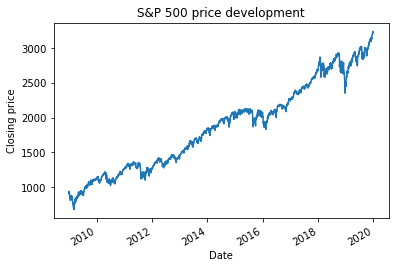

In [15]:
data = yf.download("^GSPC", start="2009-01-01", end="2019-12-31")
df = data['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig, ax = plt.subplots()
df.plot(ylabel='Closing price', title='S&P 500 price development');

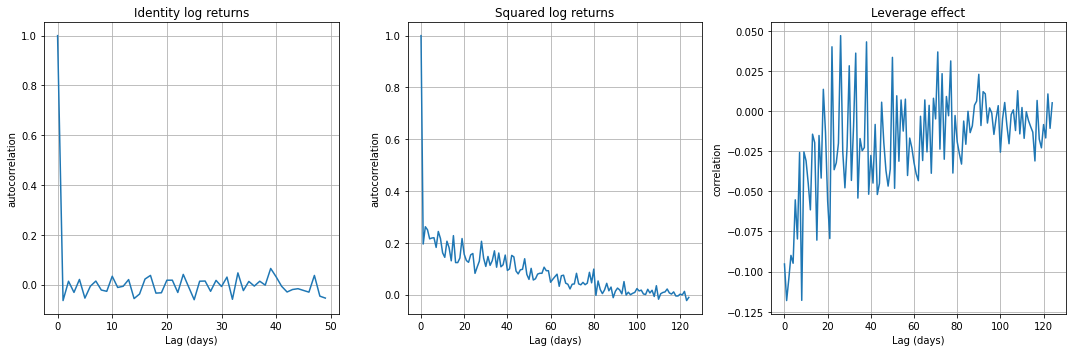

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50))
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 125))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 125, le=True))
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='Lag (days)')
plt.setp(axs[0:2], ylabel='autocorrelation')
axs[2].set_ylabel('correlation')
plt.tight_layout();

# Step 2: Rescaling data
# Step 3: Applying inverse Lambert W transform
# Step 4: Rescaling data 2nd time

In [17]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))

(-4.0, 4.0)

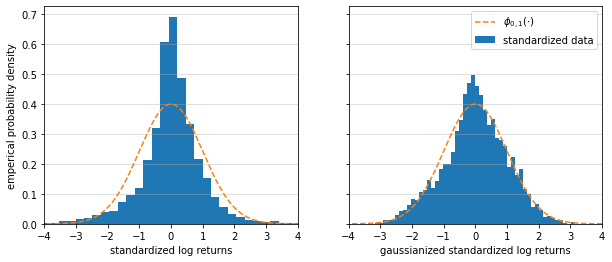

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, sharex=True)
# We plot the distribution of log returns before and after the
# lambert W inverse transform respectively (both standardized). 
# We overlay it with a standard normal.

ax[0].hist(s1.transform(log_returns), bins=50, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=50, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['$\phi_{0, 1}(\cdot)$', 'standardized data'])
ax[0].set_ylabel('emperical probability density')
ax[0].set_xlabel('standardized log returns')
ax[1].set_xlabel('gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

# Step 5: Calculating rolling windows

As I understoood, we should make subsequences of $size$ = receptive field size = $127$

![Pipeline](images/2_rolling_window.jpg)

In [19]:
# receptive field size
rfs = 127

log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

# GAN models definition and training

As suggested we use 3-dimensional noise in generator,


and rfs = 127 field size in TCN inside generator and discriminator

![Pipeline](images/3_generator_noise.jpg)

In [12]:
dilations = 2**(np.arange(6))
n_filters = 100

discriminator = make_Discriminator_TCN(dilations, n_filters, [1, rfs, 3], block_size=2)
generator = make_Generator_TCN(dilations, n_filters, [1, None, 3], block_size=2)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
class verboseGAN(GAN):
    # override the train hook method to print some metrics during training
    def train_hook(self, n_batch):
        if (n_batch + 1) % 500 == 0:
            y = self.generator(self.fixed_noise).detach().numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1, keepdims=True)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))
        
train_input = 2*rfs - 1
gan = verboseGAN(discriminator, generator, train_input, lr_d=1e-4, lr_g=3e-5, generator_input_shape=[1, None, 3])

gan.acf_real = acf(log_returns_preprocessed, 250)
gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
gan.le_real = acf(log_returns_preprocessed, 250, le=True)

# noise that stays constant for displaying metrics
gan.fixed_noise = torch.randn([128, 1, 4000 + rfs - 1, 3])

In [23]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
batch_size = 64
n_batches = 3000
additional_d_steps = 0

# It may appear that I'm stopping while acf_abs is still significantly decreasing,
# but it has the tendency to increase after ~3000 steps.
gan.train(data, batch_size, n_batches, additional_d_steps, device)

processing epoch = 0
processing epoch = 100
processing epoch = 200
processing epoch = 300
processing epoch = 400

acf: 0.3997, acf_abs: 1.3704, le: 0.9662
processing epoch = 500
processing epoch = 600
processing epoch = 700
processing epoch = 800
processing epoch = 900

acf: 0.3968, acf_abs: 1.3707, le: 0.9659
processing epoch = 1000
processing epoch = 1100
processing epoch = 1200
processing epoch = 1300
processing epoch = 1400

acf: 0.4003, acf_abs: 1.3711, le: 0.9653
processing epoch = 1500
processing epoch = 1600
processing epoch = 1700
processing epoch = 1800
processing epoch = 1900

acf: 0.3985, acf_abs: 1.3713, le: 0.9660
processing epoch = 2000
processing epoch = 2100
processing epoch = 2200
processing epoch = 2300
processing epoch = 2400

acf: 0.3975, acf_abs: 1.3688, le: 0.9636
processing epoch = 2500
processing epoch = 2600
processing epoch = 2700
processing epoch = 2800
processing epoch = 2900

acf: 0.4004, acf_abs: 1.3696, le: 0.9651


In [13]:
if False:
  torch.save(generator.state_dict(), 'trained_generator_SP500_3000stages.pt')
  torch.save(discriminator.state_dict(), 'trained_discriminator_SP500_3000stages.pt')

if True and not IN_COLAB:
  generator.load_state_dict(torch.load('trained_generator_SP500_3000stages.pt', map_location=device))
  discriminator.load_state_dict(torch.load('trained_discriminator_SP500_3000stages.pt', map_location=device))

if IN_COLAB:
  generator.load_state_dict(torch.load('quantgan/trained_generator_SP500_3000stages.pt', map_location=device))
  discriminator.load_state_dict(torch.load('quantgan/trained_discriminator_SP500_3000stages.pt', map_location=device))

Results for n > 50 generated paths

In [20]:
noise = torch.randn([128, 1, len(log_returns_preprocessed) + rfs - 1, 3])
y = generator(noise).detach().numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)
# unfortunately guassianize package doesnt support efficient column-wise transform
y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = s1.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# center the log_paths for the picture
y -= y.mean()

#We retain a majority of samples
len(y)

77

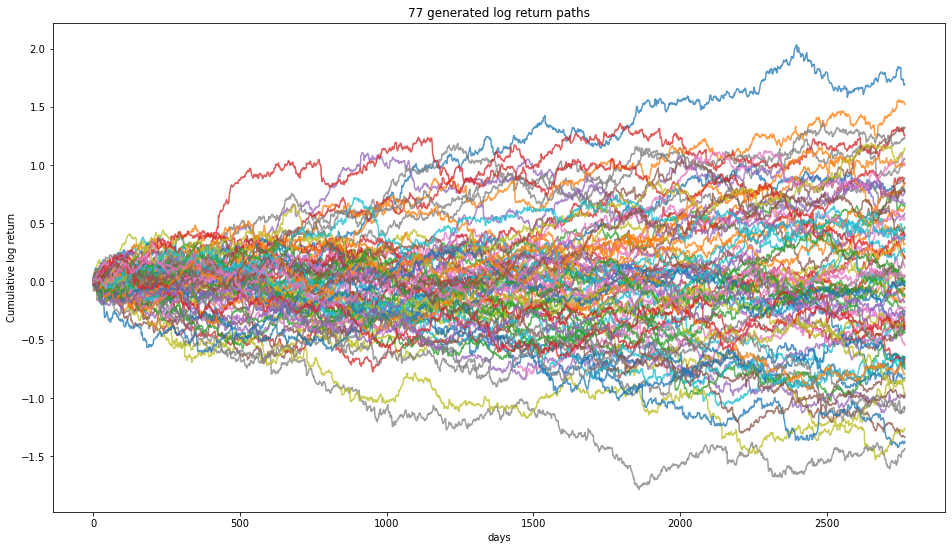

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y, axis=1).T, alpha=0.75)
ax.set_title('{} generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return');

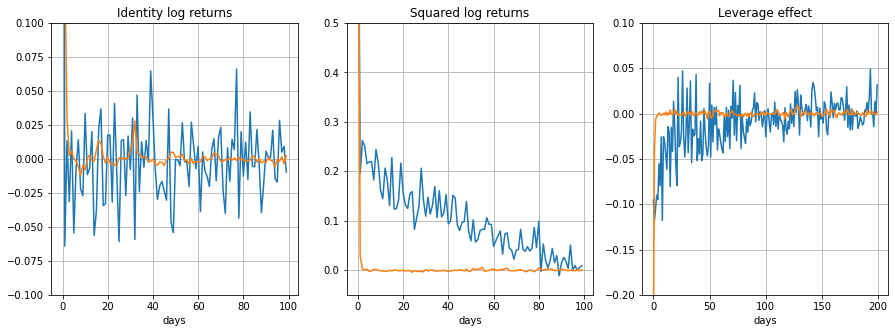

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 100))
axs[0].plot(acf(y.T, 100).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 200, le=True))
axs[2].plot(acf(y.T, 200, le=True).mean(axis=1))
axs[2].set_ylim(-0.2, 0.1)
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='days');

results for n = 5 generated paths

In [23]:
noise = torch.randn([5, 1, len(log_returns_preprocessed) + rfs - 1, 3])
y = generator(noise).detach().numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)
# unfortunately guassianize package doesnt support efficient column-wise transform
y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = s1.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# center the log_paths for the picture
y -= y.mean()

#We retain a majority of samples
len(y)

5

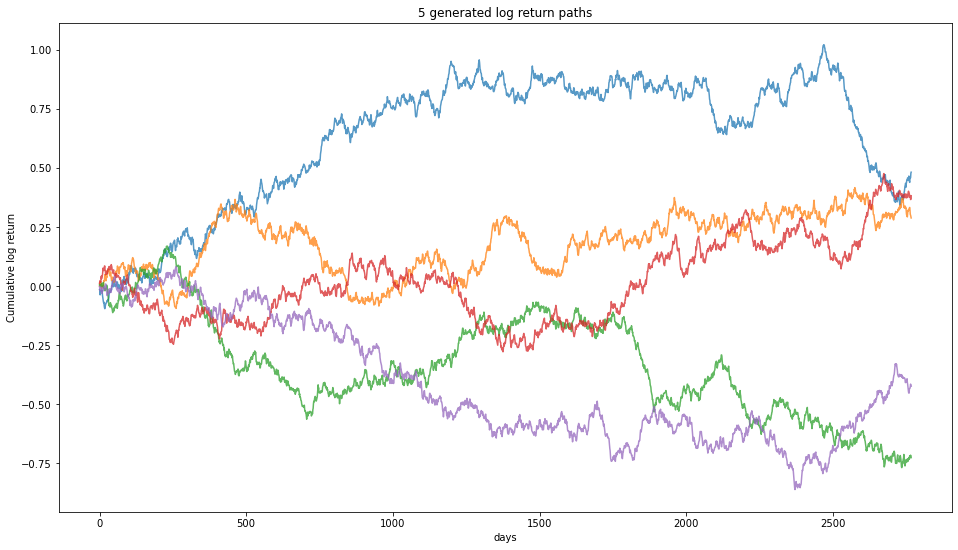

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y, axis=1).T, alpha=0.75)
ax.set_title('{} generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return');

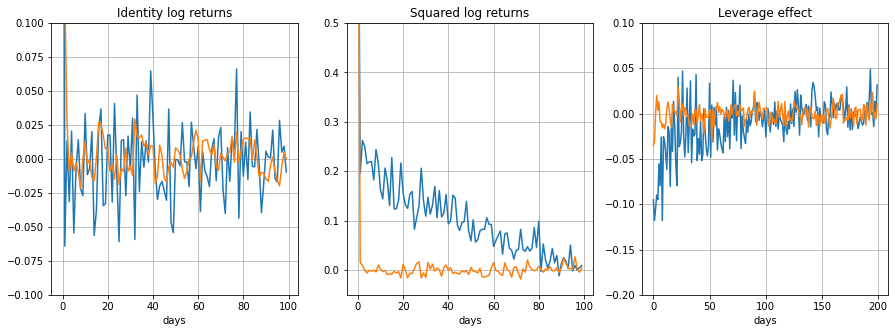

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 100))
axs[0].plot(acf(y.T, 100).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 200, le=True))
axs[2].plot(acf(y.T, 200, le=True).mean(axis=1))
axs[2].set_ylim(-0.2, 0.1)
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='days');